In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Neural Network

In [3]:
class NeuralNetwork:
    # Weights
    W = []
    # Layers
    M = []
    # Bias
    b = []
    # Dropout percentage
    D = []
    # Activation function for each layer
    A = []
    Yhat = []
    costs = []
    lossType = 'ce'
    
    def __init__(self):
        self.reset()
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __tanh(self, Z):
        return np.tanh(Z)
    
    def __relu(self,Z):
        return Z * (Z > 0)
    
    # Calls specified activation function
    def __actf(self,Z,ty):
        if ty == 'sigmoid':
            return self.__sigmoid(Z)
        elif ty == 'tanh':
            return self.__tanh(Z)
        elif ty == 'softmax':
            return self.__softmax(Z)
        elif ty == 'none':
            return Z
        else:# ty == 'relu':
            return self.__relu(Z)
        
        # Calls specified activation function derivative
    def __actf_dv(self,Z,ty):
        if ty == 'sigmoid':
            return Z*(1-Z)
        elif ty == 'tanh':
            return (1-Z*Z)
        else:# ty == 'relu':
            return np.where(Z > 0, 1, 0)
        
    def __softmax(self,A):
        expA = np.exp(A)
        return expA / expA.sum(axis=1,keepdims=True)
    
    # Cross-entropy cost for softmax
    def __cost(self,T,Y,ty):
        if ty == 'ce':
            return self.__cross_entropy(T,Y)
        else:
            return self.__sparse_cat(T,Y)
    
    def __cross_entropy(self,T,Y):
        tot = (-T * np.log(Y))
        return tot.sum()
    
    # Sparse categorical cross-entropy loss
    def __sparse_cat(self, T, Y):
        tot = 0
        for i in range(len(Y)):
            tot += -np.log(Y[i][T[i]])
        return tot;
    
    def classification_rate(self,T):
        Yhat = NeuralNetwork.Yhat
        Yp = np.argmax(Yhat,axis=1)
        print('Classification rate: ', np.mean(T == Yp))
    
    # Adds hidden layer with L nodes, d dropout
    def add_layer(self,L,a='sigmoid',d=0):
        self.M.append(L)
        self.A.append(a)
        d = min(d,1)
        d = max(d, 0)
        self.D.append(d)
        
    def __shuffle(self,X,Y,y):
        assert len(X) == len(Y) == len(y)
        p = np.random.permutation(len(X))
        return X[p],Y[p],y[p]
        
            
    # Parameters(M:Layers,W:Weights,b:bias,A:activation function,D:Dropout)
    def __forward(self,M,W,b,A,D):
        for i in range(1,len(W)+1):
            #if (i != len(W)+1):
            M[i] = self.__actf((M[i-1].dot(W[i-1]) + b[i-1]), A[i-1])
            # Dropout
            if (D[i-1] > 0):
                for j in range(len(M[i])):
                    if (random.random() < D[i-1]):
                        M[i][j] = 0
            #else:
            #    M[i] = M[i-1].dot(W[i-1]) + b[i-1]
            #    Y = self.__softmax(M[i])
        Y = M[-1]
        return Y,M
    
    def fit(self,X,y,epochs=20000,batchSize=0,learnR=10e-6,reg=0,lossType='ce',optimizer='none'):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        D = self.D
        #NeuralNetwork.actf = a
        
        
        
        # Initialize layers for M
        N = X.shape[0]
        for i in range(len(M)):
            M[i] = np.random.randn(N,M[i])
            
        # Add input and output layers to M
        K = len(set(y))
        M.insert(0,X)
        M.append(np.random.randn(N,K))
        # Add softmax to end of activation functions
        A.append('softmax')
        D.append(0)
        l = learnR
        
        # Regulate batch size
        batchSize = min(batchSize, N)
        batchSize = max(batchSize, 1)
        
        # Set indicator matrix
        Y = np.zeros((N,K))
        for i in range(N):
            Y[i,y[i]] = 1
            
        # Set weights
        for i in range(len(M)-1):
            if i == (len(M)-2):
                W.append(np.random.randn(M[i].shape[1],K) / np.sqrt(M[i].shape[1] + K))
                b.append(np.random.randn(K) / np.sqrt(K))
            else:
                W.append(np.random.randn(M[i].shape[1],M[i+1].shape[1]) / np.sqrt(M[i].shape[1] + M[i+1].shape[1]))
                b.append(np.random.randn(M[i+1].shape[1]) / np.sqrt(M[i+1].shape[1]))
        # Set cache (if using rmsprop/adam)
        if optimizer == 'rms':
            wCache = []
            bCache = []
            eps = 10e-8
            decay = 0.99
            for i in range(len(M)-1):
                if i == (len(M)-2):
                    wCache.append(np.ones((M[i].shape[1],K)))
                    bCache.append(np.ones((K)))
                else:
                    wCache.append(np.ones((M[i].shape[1],M[i+1].shape[1])))
                    bCache.append(np.ones((M[i+1].shape[1])))
        elif optimizer == 'adam':
            wM = []
            wV = []
            bM = []
            bV = []
            eps = 10e-8
            decay1 = 0.9
            decay2 = 0.999
            for i in range(len(M)-1):
                if i == (len(M)-2):
                    wM.append(np.zeros((M[i].shape[1],K)))
                    wV.append(np.zeros((M[i].shape[1],K)))
                    bM.append(np.zeros((K)))
                    bV.append(np.zeros((K)))
                else:
                    wM.append(np.zeros((M[i].shape[1],M[i+1].shape[1])))
                    wV.append(np.zeros((M[i].shape[1],M[i+1].shape[1])))
                    bM.append(np.zeros((M[i+1].shape[1])))
                    bV.append(np.zeros((M[i+1].shape[1])))
        
        costs = []
        for e in range(epochs):
            iterations = N // batchSize
            X,Y,y = self.__shuffle(X,Y,y)
            for i in range(iterations):
                start = i * batchSize
                end = (i+1) * batchSize
                batchX, batchY, sparseY = X[start:end],Y[start:end],y[start:end]
                del M[0]
                M.insert(0,batchX)
                #print(sparceY)
                Yp,Z = self.__forward(M,W,b,A,D)
                #cost = self.__cost(Y,Yp)
                if lossType == 'ce':
                    cost = self.__cost(batchY,Yp,lossType)
                else:
                    cost = self.__cost(sparseY,Yp,lossType)
                costs.append(cost)
                

                # Adjust weights
                #S = (Y - Yp)
                S = (batchY - Yp)
                n = len(M)-2
                Zt = S
                for i in range(len(M)-1):
                    # Weight and bias derivative
                    dw = Z[n].T.dot(Zt)
                    db = Zt.sum()
                    if optimizer == 'none': 
                        W[n] += l * (dw - reg*W[n])
                        b[n] += l * (db - reg*b[n])
                    elif optimizer == 'rms':
                        # rmsprop
                        wCache[n] = (decay * wCache[n]) + (1-decay) * np.square(dw)
                        bCache[n] = (decay * bCache[n]) + (1-decay) * np.square(db)
                        wDenominator = np.sqrt(wCache[n]) + eps
                        bDenominator = np.sqrt(bCache[n]) + eps
                        
                        W[n] += l * ((dw/wDenominator) - reg*W[n])
                        b[n] += l * ((db/bDenominator) - reg*b[n])
                    elif optimizer == 'adam':
                        
                        #print(wM.shape)
                        wM[n] = (decay1 * wM[n]) + (1-decay1) * dw
                        wV[n] = (decay1 * wV[n]) + (1-decay1) * np.square(dw)
                        bM[n] = (decay2 * bM[n]) + (1-decay2) * db
                        bV[n] = (decay2 * bV[n]) + (1-decay2) * np.square(db)
                        wMhat = wM[n]/(1-decay1**(epochs+1))
                        wVhat = wV[n]/(1-decay1**(epochs+1))
                        bMhat = bM[n]/(1-decay2**(epochs+1))
                        bVhat = bV[n]/(1-decay2**(epochs+1))
                        wDenom = np.sqrt(wVhat) + eps
                        bDenom = np.sqrt(bVhat) + eps
                        #print(W[n].shape, wM[n].shape, wDenom.shape)
                        W[n] += l * ((wMhat/wDenom) - reg*W[n])
                        b[n] += l * ((bMhat/bDenom) - reg*b[n])

                    if i != (len(M)-2):
                        #Update Zt
                        Zt = Zt.dot(W[n].T)*self.__actf_dv(Z[n],A[n-1])

                    n -= 1
            if e % 1000 == 0:
                print(e,costs[-1])
        self.W = W
        self.b = b
        self.M = M
        self.Yhat = Yp
        self.costs = costs
    
    def predict(self,X):
        W = self.W
        b = self.b
        M = self.M
        A = self.A
        #a = NeuralNetwork.actf
        D = self.D
        del M[0]
        M.insert(0,X)
        Yp,Z = self.__forward(M,W,b,A,D)
        NeuralNetwork.Yhat = Yp
        return Yp
    
    def plot_cost(self):
        costs = self.costs
        plt.plot(costs)
        plt.show()
    
    def reset(self):
        self.W = []
        self.b = []
        self.M = []
        self.A = []
        self.D = []
        self.lossType = 'ce'
        self.optimizer = 'none'
        self.Yhat = []
        self.costs = []

## Training Data

In [8]:
model = NeuralNetwork()

In [9]:
# Tests
Nclass = 500
X1 = np.random.randn(Nclass, 2) + np.array([0, -2])
X2 = np.random.randn(Nclass, 2) + np.array([2, 2])
X3 = np.random.randn(Nclass, 2) + np.array([-2, 2])

X = np.concatenate((X1,X2,X3), axis=0)
#X = np.vstack([X1, X2, X3])

X1_t = np.random.randn(Nclass, 2) + np.array([0, -2])
X2_t = np.random.randn(Nclass, 2) + np.array([2, 2])
X3_t = np.random.randn(Nclass, 2) + np.array([-2, 2])

X_test = np.concatenate((X1_t,X2_t,X3_t), axis=0)

Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)

In [10]:
model.add_layer(4,'relu')
model.add_layer(5)

In [11]:
# (X, Y, loss type, # iterations, batch size, learning rate, regulization)
# Loss type('ce': cross-entropy, 'sce': sparse cross-entropy)
lossType = 'ce'
epochs = 20000
batchSize = X.shape[0]
learnR = 10e-4
reg = 0
optimizer = 'adam'
model.fit(X,Y,epochs,batchSize,learnR,lossType=lossType,optimizer=optimizer)

0 1716.6486997127536
1000 111.87706910074827
2000 107.15339390223295
3000 105.87234227153182
4000 103.18008513442614
5000 101.70277000063098
6000 100.35929517786033
7000 99.09623758804018
8000 97.40108884371078
9000 96.6725051535109
10000 96.25861845723045
11000 96.00294310403437
12000 95.86367185527524
13000 95.76413854244656
14000 95.3465101792868
15000 94.95418844734579
16000 94.69947571073799
17000 94.52196575104118
18000 94.31589662663534
19000 94.13755253015542


In [12]:
#
model.predict(X_test)

array([[9.99952139e-01, 2.83294952e-05, 1.95317998e-05],
       [9.99944292e-01, 3.45508577e-05, 2.11569121e-05],
       [9.92838468e-01, 6.98296322e-03, 1.78568824e-04],
       ...,
       [2.78009189e-05, 1.16224639e-05, 9.99960577e-01],
       [7.24655817e-05, 9.84884785e-01, 1.50427498e-02],
       [2.61038479e-05, 1.15376021e-05, 9.99962359e-01]])

In [103]:
model.Yhat.shape

(128, 3)

In [104]:
model.classification_rate(Y)

Classification rate:  0.9746666666666667


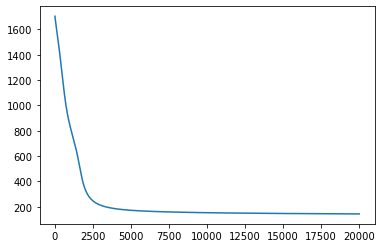

In [252]:
model.plot_cost()

## Mnist Dataset

In [3]:
import tensorflow as tf

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
xtf = x_train.copy()
xtf = xtf.reshape(60000,784)

In [8]:
xtf.shape

(60000, 784)

In [9]:
model = NeuralNetwork()

In [10]:
model.add_layer(50,'relu',.2)
model.add_layer(50,'relu',.2)

In [ ]:
# (X, Y, epochs, batch size, learning rate, regulization)
lossType = 'sce'
optimizer = 'adam'
batchSize = 128
epochs = 20000
model.fit(xtf,y_train,epochs,batchSize,lossType=lossType,optimizer=optimizer)

0 296.2532844750522
1000 111.73926422829251
2000 99.08099237674831
3000 101.48448077056233
4000 94.43363093435501
5000 84.83576032259359
6000 90.22401514785915
7000 99.83483220346677
8000 86.85053742314096
9000 101.67998596776991
10000 116.76612136851338
11000 124.51370659582938
12000 119.47471088132421
13000 94.96320464183313
14000 109.51411939981088


In [66]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
gc.collect()
%reset -f